In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets   
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from timeit import default_timer as timer

In [ ]:
class LeNET(nn.Module):
  def __init__(self, in_channels=1):
    super(LeNET, self).__init__()
    self.in_channels = in_channels
    self.relu = nn.ReLU()
    self.pool = nn.AvgPool2d(kernel_size = (2,2), stride=(2,2))
    self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 6, kernel_size = (5,5), stride = (1,1), padding = (2,2))
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = (5,5), stride = (1,1), padding = (0,0))
    self.conv3 = nn.Conv2d(in_channels = 16, out_channels =120, kernel_size = (5,5), stride = (1,1), padding = (0,0))
    self.linear1 = nn.Linear(120, 84)
    self.linear2 = nn.Linear(84,10)

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.pool(x)
    x = self.relu(self.conv2(x))
    x = self.pool(x)
    x = self.relu(self.conv3(x))# num_examples x 120 x 1 x 1 -- > num_examples x 120
    x = x.reshape(x.shape[0], -1)
    x = self.relu(self.linear1(x))
    x = self.linear2(x)
    return x 

In [ ]:
x = torch.randn(64, 1, 28, 28)
model = LeNET()
print(model(x).shape)

torch.Size([64, 10])


In [ ]:
#Setup train data
train_data = datasets.MNIST(root="data",
                                   train=True,
                                   download=True,
                                   transform=transforms.ToTensor())

test_data = datasets.MNIST(root="data",
                                   train=False,
                                   download=True,
                                   transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [ ]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

Image Shape: torch.Size([1, 28, 28])


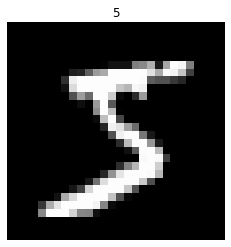

In [ ]:
#Visualising the data
#understanding input and output shape
image, label = train_data[0]
print(f"Image Shape: {image.shape}")
plt.imshow(image.squeeze(), cmap="gray")
plt.title(label);
plt.axis(False);

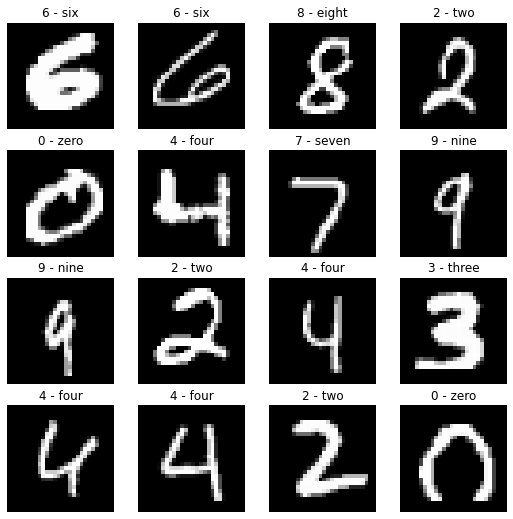

In [ ]:
#Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [ ]:
#Prepare Dataloader that prepares our data into python iterable
#We turn our data into mini batches since it is more computationally efficient
from torch.utils.data import DataLoader

#Setup the batch size hyperparameter
BATCH_SIZE = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

#Turn datasets into iterables(batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model_LENET_0 = LeNET().to(device)

In [ ]:
def print_train_time(start:float,
                     end:float,
                     device:torch.device=None):
  total_time = end-start
  print(f"Train time on {device} : {total_time:.3f} seconds")
  return total_time

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_LENET_0.parameters(), lr=0.03)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
#Functionizing training and evaluation/testing loops
#We create a function for training loop - train_step()
#testing loop - test_step()

def train_step(model:torch.nn.Module, data_loader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,optimizer:torch.optim.Optimizer,accuracy_fn,device:torch.device=device):
  #Performs training step on model trying to learn from data loader
  train_loss, train_acc = 0, 0
  #Put model in training mode
  model.train()
  #Add a loop through the training batches 
  for batch, (X,y) in enumerate(data_loader):#Enumerate helps keeping track of batches
    #Put data on target device
    X,y = X.to(device), y.to(device)
    #forward pass
    y_pred = model(X)
    #loss and accuracy
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    #Optimizer zero grad
    optimizer.zero_grad()
    #Loss backward
    loss.backward()
    #Step
    optimizer.step()

  #Adjust the training loss so that it gives us the loss per epoch an not per batch
  #Divide total train loss by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train Loss: {train_loss:.5f}, Train acc: {train_acc:.2f}%")

In [ ]:
def test_step(model:torch.nn.Module, data_loader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,optimizer:torch.optim.Optimizer,accuracy_fn,device:torch.device=device):
  #Performs training step on model trying to learn from data loader
  test_loss, test_acc = 0, 0
  #Put model in training mode
  model.eval()
  #Add a loop through the training batches 
  with torch.inference_mode():
    for X,y in data_loader:#Enumerate helps keeping track of batches
      #Put data on target device
      X,y = X.to(device), y.to(device)
      #forward pass
      test_pred = model(X)
      #loss and accuracy
      loss = loss_fn(test_pred, y)
      test_loss += loss
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    #Adjust the training loss so that it gives us the loss per epoch an not per batch
    #Divide total train loss by length of train dataloader
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

In [ ]:
torch.manual_seed(42)

#Measure time
train_time_start_on_gpu = timer()

#Set epochs
epochs=50

#Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} ----")
  train_step(model=model_LENET_0, data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
  test_step(model=model_LENET_0,data_loader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 ----
Train Loss: 1.12607, Train acc: 60.27%


  2%|▏         | 1/50 [00:38<31:07, 38.12s/it]

Test Loss: 0.21004, Test acc: 93.78%
Epoch: 1 ----
Train Loss: 0.18793, Train acc: 94.13%


  4%|▍         | 2/50 [01:06<26:08, 32.67s/it]

Test Loss: 0.11429, Test acc: 96.43%
Epoch: 2 ----
Train Loss: 0.11511, Train acc: 96.42%


  6%|▌         | 3/50 [01:36<24:18, 31.03s/it]

Test Loss: 0.08526, Test acc: 97.28%
Epoch: 3 ----
Train Loss: 0.08734, Train acc: 97.24%


  8%|▊         | 4/50 [02:06<23:42, 30.92s/it]

Test Loss: 0.07410, Test acc: 97.68%
Epoch: 4 ----
Train Loss: 0.06942, Train acc: 97.83%


 10%|█         | 5/50 [02:35<22:41, 30.26s/it]

Test Loss: 0.06015, Test acc: 98.03%
Epoch: 5 ----
Train Loss: 0.05842, Train acc: 98.14%


 12%|█▏        | 6/50 [03:04<21:47, 29.72s/it]

Test Loss: 0.07156, Test acc: 97.59%
Epoch: 6 ----
Train Loss: 0.05069, Train acc: 98.46%


 14%|█▍        | 7/50 [03:33<21:03, 29.39s/it]

Test Loss: 0.05183, Test acc: 98.25%
Epoch: 7 ----
Train Loss: 0.04515, Train acc: 98.55%


 16%|█▌        | 8/50 [04:04<20:55, 29.90s/it]

Test Loss: 0.04518, Test acc: 98.57%
Epoch: 8 ----
Train Loss: 0.04001, Train acc: 98.75%


 18%|█▊        | 9/50 [04:33<20:12, 29.58s/it]

Test Loss: 0.04764, Test acc: 98.47%
Epoch: 9 ----
Train Loss: 0.03602, Train acc: 98.85%


 20%|██        | 10/50 [05:02<19:36, 29.40s/it]

Test Loss: 0.04237, Test acc: 98.54%
Epoch: 10 ----
Train Loss: 0.03121, Train acc: 99.02%


 22%|██▏       | 11/50 [05:31<19:00, 29.24s/it]

Test Loss: 0.05122, Test acc: 98.45%
Epoch: 11 ----
Train Loss: 0.02987, Train acc: 99.03%


 24%|██▍       | 12/50 [05:59<18:22, 29.02s/it]

Test Loss: 0.04555, Test acc: 98.47%
Epoch: 12 ----
Train Loss: 0.02621, Train acc: 99.14%


 26%|██▌       | 13/50 [06:29<17:59, 29.17s/it]

Test Loss: 0.04254, Test acc: 98.63%
Epoch: 13 ----
Train Loss: 0.02383, Train acc: 99.21%


 28%|██▊       | 14/50 [07:06<18:56, 31.57s/it]

Test Loss: 0.04320, Test acc: 98.56%
Epoch: 14 ----
Train Loss: 0.02208, Train acc: 99.25%


 30%|███       | 15/50 [07:35<17:57, 30.79s/it]

Test Loss: 0.04150, Test acc: 98.74%
Epoch: 15 ----
Train Loss: 0.01993, Train acc: 99.35%


 32%|███▏      | 16/50 [08:03<17:06, 30.19s/it]

Test Loss: 0.04113, Test acc: 98.70%
Epoch: 16 ----
Train Loss: 0.01780, Train acc: 99.47%


 34%|███▍      | 17/50 [08:38<17:16, 31.42s/it]

Test Loss: 0.04680, Test acc: 98.48%
Epoch: 17 ----
Train Loss: 0.01778, Train acc: 99.42%


 36%|███▌      | 18/50 [09:06<16:17, 30.54s/it]

Test Loss: 0.04345, Test acc: 98.63%
Epoch: 18 ----
Train Loss: 0.01626, Train acc: 99.44%


 38%|███▊      | 19/50 [09:34<15:24, 29.83s/it]

Test Loss: 0.03699, Test acc: 98.90%
Epoch: 19 ----
Train Loss: 0.01422, Train acc: 99.54%


 40%|████      | 20/50 [10:03<14:40, 29.36s/it]

Test Loss: 0.04128, Test acc: 98.84%
Epoch: 20 ----
Train Loss: 0.01316, Train acc: 99.57%


 42%|████▏     | 21/50 [10:31<14:00, 28.99s/it]

Test Loss: 0.04129, Test acc: 98.80%
Epoch: 21 ----
Train Loss: 0.01176, Train acc: 99.61%


 44%|████▍     | 22/50 [10:59<13:24, 28.73s/it]

Test Loss: 0.03922, Test acc: 98.85%
Epoch: 22 ----
Train Loss: 0.01086, Train acc: 99.64%


 46%|████▌     | 23/50 [11:27<12:53, 28.63s/it]

Test Loss: 0.04273, Test acc: 98.77%
Epoch: 23 ----
Train Loss: 0.00941, Train acc: 99.70%


 48%|████▊     | 24/50 [11:58<12:40, 29.23s/it]

Test Loss: 0.04008, Test acc: 98.86%
Epoch: 24 ----
Train Loss: 0.01031, Train acc: 99.66%


 50%|█████     | 25/50 [12:26<12:03, 28.94s/it]

Test Loss: 0.04568, Test acc: 98.77%
Epoch: 25 ----
Train Loss: 0.00878, Train acc: 99.70%


 52%|█████▏    | 26/50 [12:54<11:29, 28.73s/it]

Test Loss: 0.04585, Test acc: 98.69%
Epoch: 26 ----
Train Loss: 0.00821, Train acc: 99.76%


 54%|█████▍    | 27/50 [13:23<10:57, 28.57s/it]

Test Loss: 0.04137, Test acc: 98.82%
Epoch: 27 ----
Train Loss: 0.00647, Train acc: 99.79%


 56%|█████▌    | 28/50 [13:51<10:27, 28.53s/it]

Test Loss: 0.04868, Test acc: 98.71%
Epoch: 28 ----
Train Loss: 0.00673, Train acc: 99.79%


 58%|█████▊    | 29/50 [14:20<09:59, 28.56s/it]

Test Loss: 0.04382, Test acc: 98.77%
Epoch: 29 ----
Train Loss: 0.00448, Train acc: 99.88%


 60%|██████    | 30/50 [14:48<09:31, 28.59s/it]

Test Loss: 0.05513, Test acc: 98.62%
Epoch: 30 ----
Train Loss: 0.00499, Train acc: 99.83%


 62%|██████▏   | 31/50 [15:17<09:03, 28.61s/it]

Test Loss: 0.04789, Test acc: 98.73%
Epoch: 31 ----
Train Loss: 0.00624, Train acc: 99.82%


 64%|██████▍   | 32/50 [15:45<08:34, 28.57s/it]

Test Loss: 0.04489, Test acc: 98.80%
Epoch: 32 ----
Train Loss: 0.00520, Train acc: 99.85%


 66%|██████▌   | 33/50 [16:16<08:16, 29.20s/it]

Test Loss: 0.05239, Test acc: 98.75%
Epoch: 33 ----
Train Loss: 0.00435, Train acc: 99.88%


 68%|██████▊   | 34/50 [16:44<07:42, 28.91s/it]

Test Loss: 0.04976, Test acc: 98.77%
Epoch: 34 ----
Train Loss: 0.00447, Train acc: 99.86%


 70%|███████   | 35/50 [17:13<07:11, 28.75s/it]

Test Loss: 0.04622, Test acc: 98.79%
Epoch: 35 ----
Train Loss: 0.00387, Train acc: 99.89%


 72%|███████▏  | 36/50 [17:41<06:40, 28.64s/it]

Test Loss: 0.04873, Test acc: 98.81%
Epoch: 36 ----
Train Loss: 0.00291, Train acc: 99.92%


 74%|███████▍  | 37/50 [18:10<06:11, 28.58s/it]

Test Loss: 0.05927, Test acc: 98.45%
Epoch: 37 ----
Train Loss: 0.00357, Train acc: 99.89%


 76%|███████▌  | 38/50 [18:38<05:42, 28.55s/it]

Test Loss: 0.05196, Test acc: 98.69%
Epoch: 38 ----
Train Loss: 0.00283, Train acc: 99.91%


 78%|███████▊  | 39/50 [19:07<05:14, 28.57s/it]

Test Loss: 0.04470, Test acc: 98.84%
Epoch: 39 ----
Train Loss: 0.00276, Train acc: 99.92%


 80%|████████  | 40/50 [19:35<04:45, 28.60s/it]

Test Loss: 0.04743, Test acc: 98.80%
Epoch: 40 ----
Train Loss: 0.00275, Train acc: 99.91%


 82%|████████▏ | 41/50 [20:04<04:16, 28.55s/it]

Test Loss: 0.05399, Test acc: 98.66%
Epoch: 41 ----
Train Loss: 0.00170, Train acc: 99.96%


 84%|████████▍ | 42/50 [20:34<03:52, 29.11s/it]

Test Loss: 0.04987, Test acc: 98.82%
Epoch: 42 ----
Train Loss: 0.00767, Train acc: 99.74%


 86%|████████▌ | 43/50 [21:03<03:22, 28.86s/it]

Test Loss: 0.04864, Test acc: 98.84%
Epoch: 43 ----
Train Loss: 0.00313, Train acc: 99.90%


 88%|████████▊ | 44/50 [21:31<02:52, 28.68s/it]

Test Loss: 0.04790, Test acc: 98.89%
Epoch: 44 ----
Train Loss: 0.00131, Train acc: 99.97%


 90%|█████████ | 45/50 [21:59<02:22, 28.58s/it]

Test Loss: 0.05181, Test acc: 98.75%
Epoch: 45 ----
Train Loss: 0.00120, Train acc: 99.96%


 92%|█████████▏| 46/50 [22:28<01:54, 28.64s/it]

Test Loss: 0.04827, Test acc: 98.86%
Epoch: 46 ----
Train Loss: 0.00122, Train acc: 99.97%


 94%|█████████▍| 47/50 [22:57<01:26, 28.70s/it]

Test Loss: 0.04930, Test acc: 98.90%
Epoch: 47 ----
Train Loss: 0.00064, Train acc: 99.99%


 96%|█████████▌| 48/50 [23:25<00:57, 28.56s/it]

Test Loss: 0.04832, Test acc: 98.89%
Epoch: 48 ----
Train Loss: 0.00047, Train acc: 99.99%


 98%|█████████▊| 49/50 [23:54<00:28, 28.56s/it]

Test Loss: 0.05152, Test acc: 98.84%
Epoch: 49 ----
Train Loss: 0.00033, Train acc: 100.00%


100%|██████████| 50/50 [24:22<00:00, 29.25s/it]

Test Loss: 0.04811, Test acc: 98.97%
Train time on cpu : 1462.265 seconds


In [ ]:
#Now we save the model
from pathlib import Path
#Create the model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
#Create the model save path
MODEL_NAME = "01_LENET_MNIST.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

In [ ]:
#Saving the model
torch.save(obj=model_LENET_0.state_dict(),
           f=MODEL_SAVE_PATH)
print(f'Saved at {MODEL_SAVE_PATH}')

Saved at models/01_LENET_MNIST.pth


In [ ]:
#Loading the model
#Create a new instance of the model and update the parameters
model_LENET_MNIST = LeNET().to(device)
model_LENET_MNIST.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device=device):
  loss,acc = 0, 0
  #Returns a dictionary containing the results of the model predicting on data_loader
  model.eval()
  with torch.inference_mode():
    for X,y in tqdm(data_loader):
      X,y = X.to(device), y.to(device)
      #Make predictions
      y_pred = model(X)

      #Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))
    #Scale the loss and acc to find the average loss and acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name":model.__class__.__name__,
          "model_loss":loss.item(),
          "model_acc":acc}

In [ ]:
#Get model results
model_LENET_MNIST_results = eval_model(
    model=model_LENET_MNIST,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_LENET_MNIST_results

100%|██████████| 313/313 [00:02<00:00, 133.28it/s]


{'model_name': 'LeNET',
 'model_loss': 0.04811466857790947,
 'model_acc': 98.97164536741214}

Fashion MNIST


In [ ]:
train_data = datasets.FashionMNIST(root="data",
                                   train=True,
                                   download=True,
                                   transform=transforms.ToTensor())

test_data = datasets.FashionMNIST(root="data",
                                   train=False,
                                   download=True,
                                   transform=transforms.ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
class_to_idx, class_names

({'T-shirt/top': 0,
  'Trouser': 1,
  'Pullover': 2,
  'Dress': 3,
  'Coat': 4,
  'Sandal': 5,
  'Shirt': 6,
  'Sneaker': 7,
  'Bag': 8,
  'Ankle boot': 9},
 ['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'])

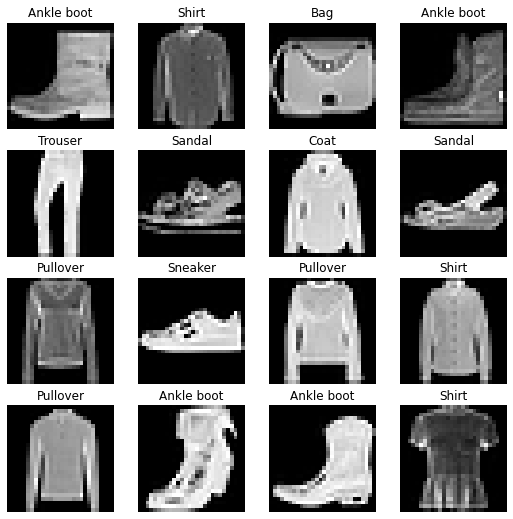

In [ ]:
#Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [ ]:
#Prepare Dataloader that prepares our data into python iterable
#We turn our data into mini batches since it is more computationally efficient
from torch.utils.data import DataLoader

#Setup the batch size hyperparameter
BATCH_SIZE = 32

#Turn datasets into iterables(batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model_LENET_1 = LeNET().to(device)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_LENET_1.parameters(), lr=0.03)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
torch.manual_seed(42)

#Measure time
train_time_start_on_gpu = timer()

#Set epochs
epochs=50

#Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} ----")
  train_step(model=model_LENET_1, data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
  test_step(model=model_LENET_1,data_loader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 ----
Train Loss: 1.10603, Train acc: 58.18%


  2%|▏         | 1/50 [00:29<23:44, 29.06s/it]

Test Loss: 0.66532, Test acc: 74.17%
Epoch: 1 ----
Train Loss: 0.54818, Train acc: 79.12%


  4%|▍         | 2/50 [00:56<22:29, 28.12s/it]

Test Loss: 0.51485, Test acc: 80.34%
Epoch: 2 ----
Train Loss: 0.46273, Train acc: 82.78%


  6%|▌         | 3/50 [01:24<21:48, 27.84s/it]

Test Loss: 0.44955, Test acc: 83.09%
Epoch: 3 ----
Train Loss: 0.41775, Train acc: 84.45%


  8%|▊         | 4/50 [01:51<21:14, 27.71s/it]

Test Loss: 0.42305, Test acc: 84.43%
Epoch: 4 ----
Train Loss: 0.38525, Train acc: 85.66%


 10%|█         | 5/50 [02:19<20:46, 27.69s/it]

Test Loss: 0.41764, Test acc: 85.15%
Epoch: 5 ----
Train Loss: 0.36109, Train acc: 86.68%


 12%|█▏        | 6/50 [02:46<20:19, 27.71s/it]

Test Loss: 0.40662, Test acc: 85.25%
Epoch: 6 ----
Train Loss: 0.34348, Train acc: 87.28%


 14%|█▍        | 7/50 [03:14<19:51, 27.71s/it]

Test Loss: 0.37096, Test acc: 86.42%
Epoch: 7 ----
Train Loss: 0.32926, Train acc: 87.78%


 16%|█▌        | 8/50 [03:42<19:23, 27.71s/it]

Test Loss: 0.35607, Test acc: 87.18%
Epoch: 8 ----
Train Loss: 0.31693, Train acc: 88.21%


 18%|█▊        | 9/50 [04:11<19:18, 28.26s/it]

Test Loss: 0.35705, Test acc: 87.20%
Epoch: 9 ----
Train Loss: 0.30591, Train acc: 88.66%


 20%|██        | 10/50 [04:39<18:39, 27.99s/it]

Test Loss: 0.34074, Test acc: 87.30%
Epoch: 10 ----
Train Loss: 0.29706, Train acc: 88.86%


 22%|██▏       | 11/50 [05:06<18:04, 27.82s/it]

Test Loss: 0.33680, Test acc: 87.87%
Epoch: 11 ----
Train Loss: 0.28796, Train acc: 89.32%


 24%|██▍       | 12/50 [05:34<17:33, 27.72s/it]

Test Loss: 0.33319, Test acc: 88.34%
Epoch: 12 ----
Train Loss: 0.28011, Train acc: 89.62%


In [ ]:
#Now we save the model
from pathlib import Path
#Create the model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
#Create the model save path
MODEL_NAME = "02_LENET_FashionMNIST.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

In [ ]:
#Saving the model
torch.save(obj=model_LENET_1.state_dict(),
           f=MODEL_SAVE_PATH)
print(f'Saved at {MODEL_SAVE_PATH}')

In [ ]:
#Loading the model
#Create a new instance of the model and update the parameters
model_LENET_FashionMNIST = LeNET().to(device)
model_LENET_FashionMNIST.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

In [ ]:
#Get model results
model_LENET_FashionMNIST_results = eval_model(
    model=model_LENET_FashionMNIST,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_LENET_FashionMNIST_results

CIFAR 10


In [ ]:
train_data = datasets.CIFAR10(root="data",
                                   train=True,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(28,28)),transforms.ToTensor()]))

test_data = datasets.CIFAR10(root="data",
                                   train=False,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(28,28)),transforms.ToTensor()]))

In [ ]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
class_to_idx, class_names

In [ ]:
#Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.permute(1, 2, 0))#(c,h,w) moves channel to the back in accordance to the matplotlib format
  plt.title(class_names[label])
  plt.axis(False)

In [ ]:
#Prepare Dataloader that prepares our data into python iterable
#We turn our data into mini batches since it is more computationally efficient
from torch.utils.data import DataLoader

#Setup the batch size hyperparameter
BATCH_SIZE = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

#Turn datasets into iterables(batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model_LENET_2 = LeNET(in_channels=3).to(device)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_LENET_2.parameters(), lr=0.03)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
torch.manual_seed(42)

#Measure time
train_time_start_on_gpu = timer()

#Set epochs
epochs=50

#Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} ----")
  train_step(model=model_LENET_2, data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
  test_step(model=model_LENET_2,data_loader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

In [ ]:
#Now we save the model
from pathlib import Path
#Create the model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
#Create the model save path
MODEL_NAME = "03_LENET_CIFAR10pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

In [ ]:
#Saving the model
torch.save(obj=model_LENET_2.state_dict(),
           f=MODEL_SAVE_PATH)
print(f'Saved at {MODEL_SAVE_PATH}')

In [ ]:
#Loading the model
#Create a new instance of the model and update the parameters
model_LENET_CIFAR10 = LeNET(in_channels=3).to(device)
model_LENET_CIFAR10.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

In [ ]:
#Get model results
model_LENET_CIFAR10_results = eval_model(
    model=model_LENET_CIFAR10,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_LENET_CIFAR10_results

CIFAR100

In [ ]:
train_data = datasets.CIFAR100(root="data",
                                   train=True,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(28,28)),transforms.ToTensor()]))

test_data = datasets.CIFAR100(root="data",
                                   train=False,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(28,28)),transforms.ToTensor()]))

In [ ]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
class_to_idx, class_names

In [ ]:
#Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.permute(1, 2, 0))#(c,h,w) moves channel to the back in accordance to the matplotlib format
  plt.title(class_names[label])
  plt.axis(False)

In [ ]:
#Prepare Dataloader that prepares our data into python iterable
#We turn our data into mini batches since it is more computationally efficient
from torch.utils.data import DataLoader

#Setup the batch size hyperparameter
BATCH_SIZE = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

#Turn datasets into iterables(batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model_LENET_3 = LeNET(in_channels=3).to(device)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_LENET_3.parameters(), lr=0.03)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
torch.manual_seed(42)

#Measure time
train_time_start_on_gpu = timer()

#Set epochs
epochs=50

#Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} ----")
  train_step(model=model_LENET_3, data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
  test_step(model=model_LENET_3,data_loader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

In [ ]:
#Now we save the model
from pathlib import Path
#Create the model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
#Create the model save path
MODEL_NAME = "04_LENET_CIFAR100pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

In [ ]:
#Saving the model
torch.save(obj=model_LENET_3.state_dict(),
           f=MODEL_SAVE_PATH)
print(f'Saved at {MODEL_SAVE_PATH}')

In [ ]:
#Loading the model
#Create a new instance of the model and update the parameters
model_LENET_CIFAR100 = LeNET(in_channels=3).to(device)
model_LENET_CIFAR100.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

In [ ]:
#Get model results
model_LENET_CIFAR100_results = eval_model(
    model=model_LENET_CIFAR100,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_LENET_CIFAR100_results